In [1]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs1/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs1/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'planck_wgt_flux',
            'option_wgt',
            'fac_meank',
            'klin']


def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [3]:
analysis = scripts.Analysis()

In [4]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs1/home/jackyu/radiation/crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'co2',
                          'band03c_wn_720_800',
                          'ng_9',
                          'g_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__2__4',
                          'getabsth_auto__auto__semiauto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_.6_.4_.7___.7_.5__.3_.4_.85_.95',
                          'bigsum',
                          'option_wgt_1',
                          'chou_0501_-_manual_abscom2_-_151f63b',
                          'atmpro_trp')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [5]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs1/home/jackyu/radiation/crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'co2',
                          'band03c_wn_720_800',
                          'ng_9',
                          'g_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__2__4',
                          'getabsth_auto__auto__semiauto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_.6_.4_.7___.7_.5__.3_.4_.85_.95',
                          'bigsum',
                          'option_wgt_1',
                          'chou_0501_-_manual_abscom2_-_151f63b',
                          'atmpro_trp')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [6]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(range(1, 9 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-4, 50)

In [7]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [8]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [9]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [10]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 720

nband = 80

nv = 200

dv = 0.005

tsfc = 300.0

ng = 9

nref = 3

p_refs = (/ 1,  10, 500 /)

t_refs = (/ 250, 250, 250 /)

ng_refs = (/ 3,   2,   4 /)

data wgt
     &     /.95, .85, .4, .3,
     &     .5, .7,
     &     .7, .4, .6/

planck_wgt_flux = 2

option_wgt = 1

klin = 6.375563e-24

include 'trp75.pro'


In [11]:
fig.display_hrefanchor()

In [12]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [13]:
table_dgdgs.display_hrefanchor()

In [14]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [15]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [16]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

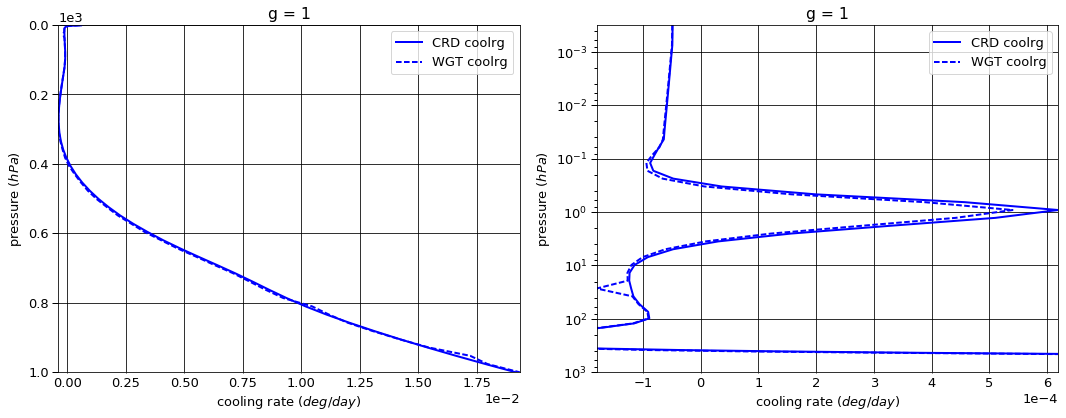

# Figure: cooling rate g-group 2

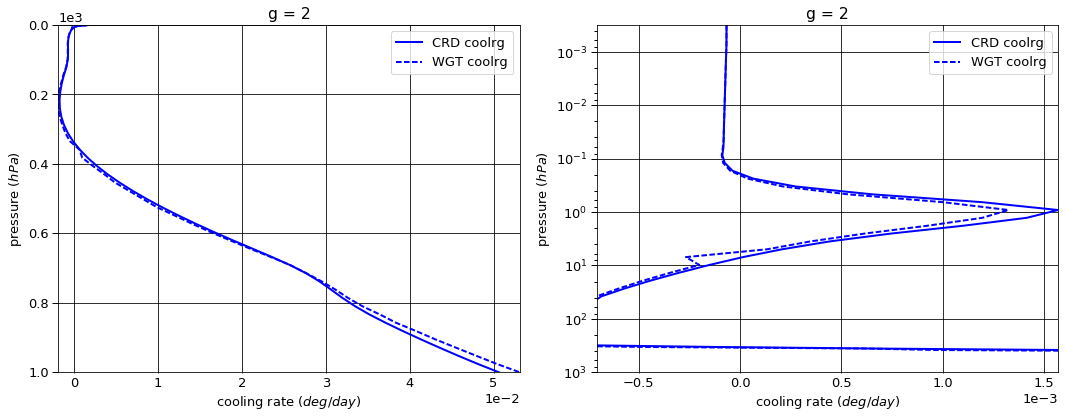

# Figure: cooling rate g-group 3

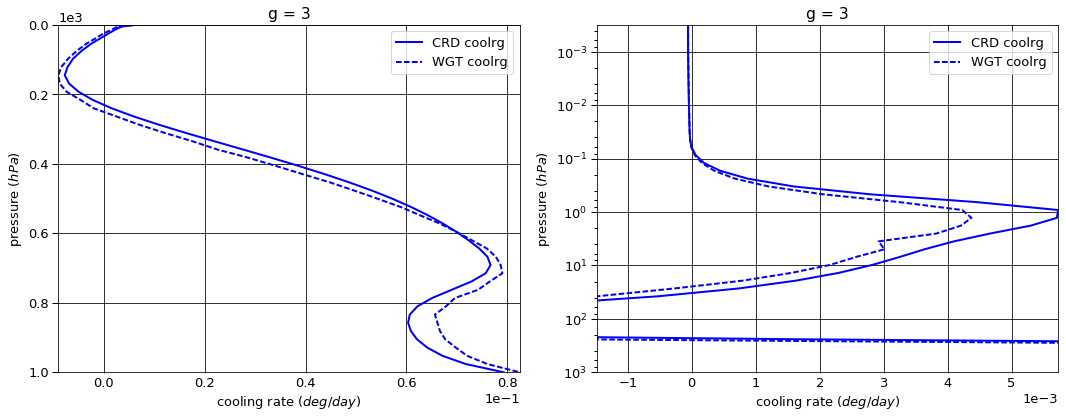

# Figure: cooling rate g-group 4

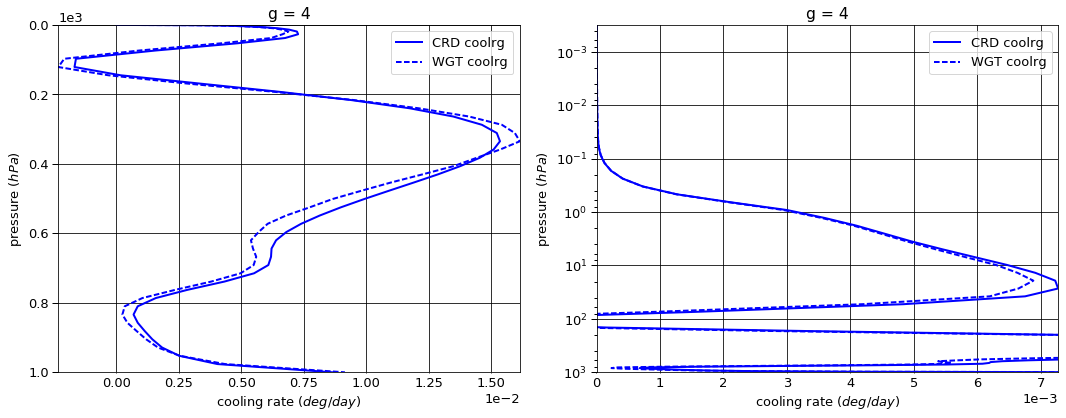

# Figure: cooling rate g-group 5

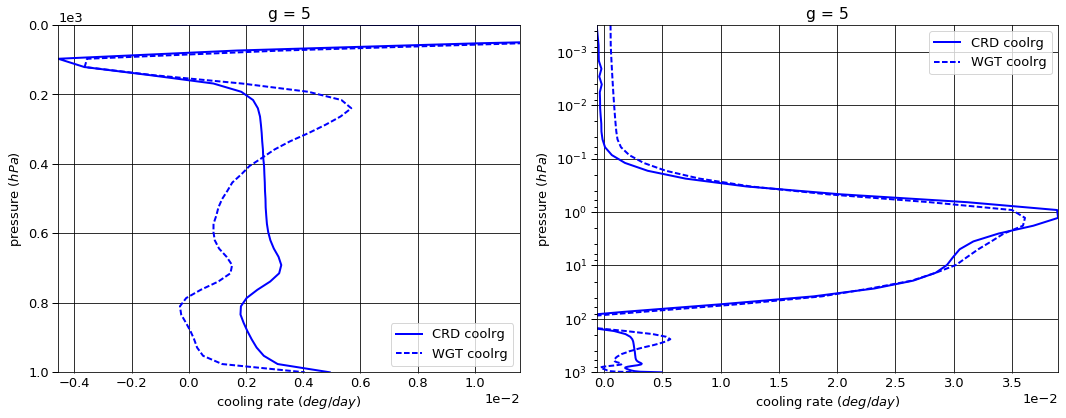

# Figure: cooling rate g-group 6

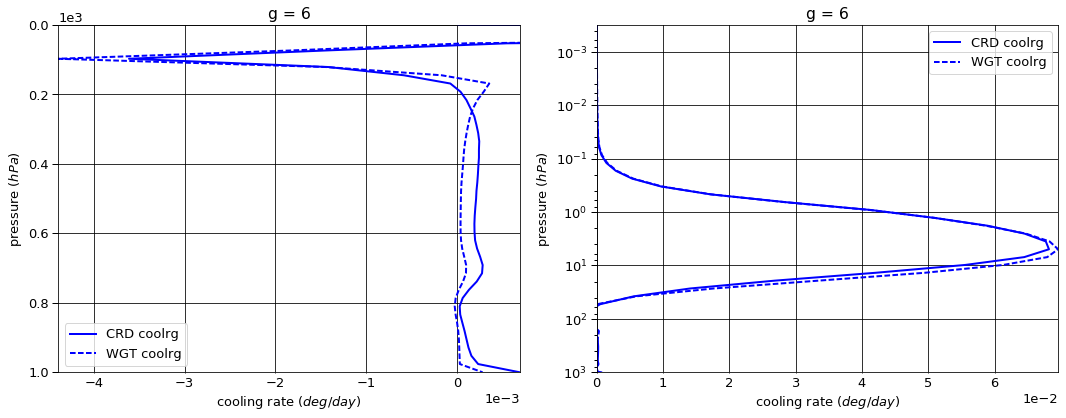

# Figure: cooling rate g-group 7

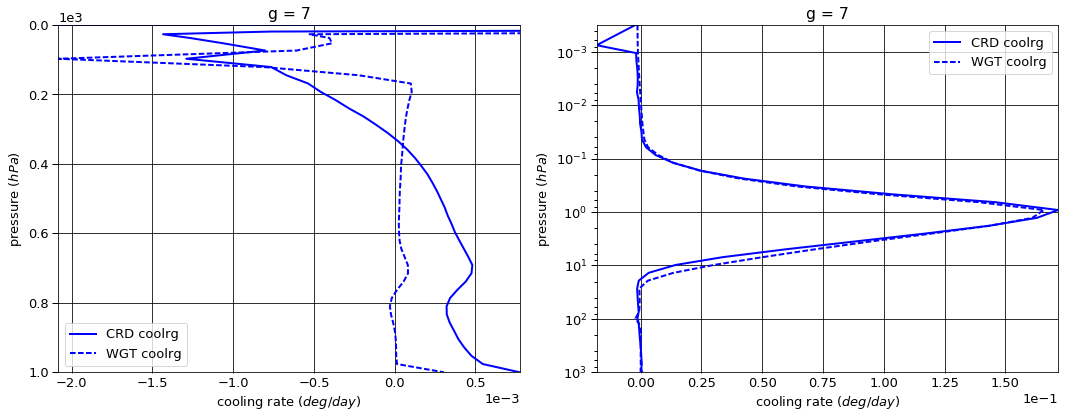

# Figure: cooling rate g-group 8

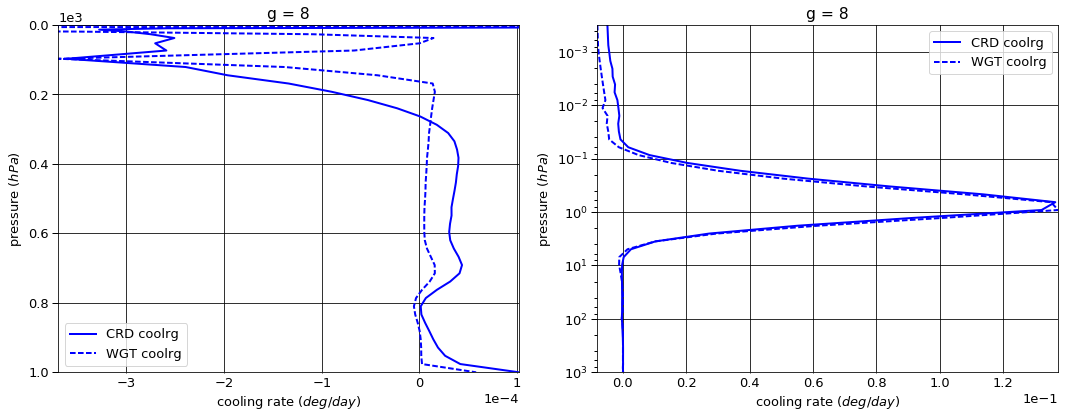

# Figure: cooling rate g-group 9

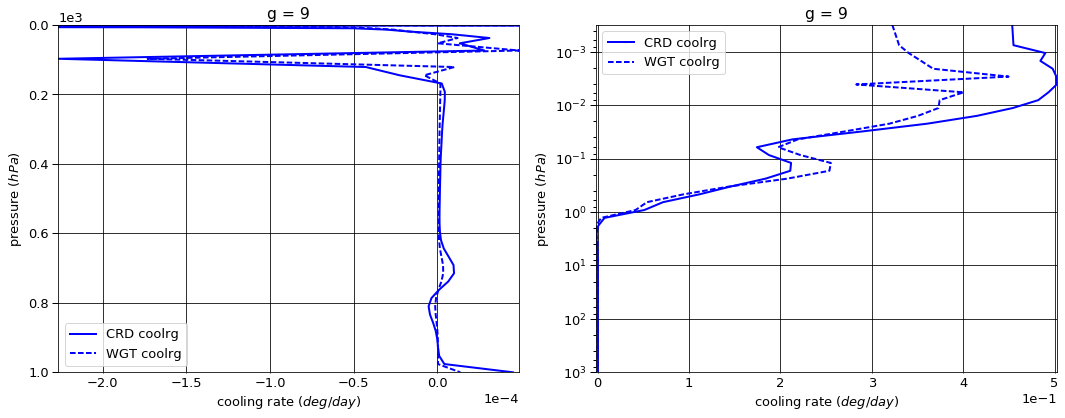

# Figure: cooling rate g-group total

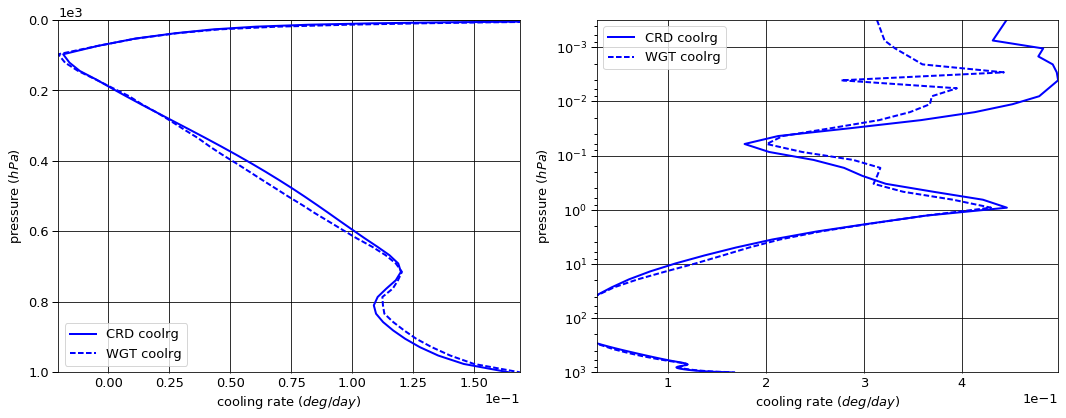

In [17]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [18]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1     -12.566853  0.000000 -12.566853
  1013.0   76    -12.734346  0.713815 -12.020531
2 0.0      1      -6.735412  0.000000  -6.735412
  1013.0   76     -7.498147  2.600123  -4.898024
3 0.0      1      -6.588322  0.000000  -6.588322
  1013.0   76    -10.421166  8.773812  -1.647353
4 0.0      1      -0.848308  0.000000  -0.848308
  1013.0   76     -2.450671  2.406164  -0.044507
5 0.0      1      -0.494419  0.000000  -0.494419
  1013.0   76     -1.383392  1.276956  -0.106436
6 0.0      1      -0.149902  0.000000  -0.149902
  1013.0   76     -0.430133  0.425539  -0.004594
7 0.0      1      -0.108200  0.000000  -0.108200
  1013.0   76     -0.222130  0.205394  -0.016736
8 0.0      1      -0.023508  0.000000  -0.023508
  1013.0   76     -0.042695  0.042091  -0.000604
9 0.0      1      -0.014733  0.000000  -0.014733
  1013.0   76     -0.040829  0.040689  -0.000140


WGT


flug      fldg      fnetg
g pressure level                                
1 0.0      1     -12.567481  0.000000 -12.567481
  1013.0   76    -12.734346  0.711279 -12.023067
2 0.0      1      -6.734392  0.000000  -6.734392
  1013.0   76     -7.498147  2.627910  -4.870237
3 0.0      1      -6.624251  0.000000  -6.624251
  1013.0   76    -10.421166  8.745110  -1.676056
4 0.0      1      -0.803771  0.000000  -0.803771
  1013.0   76     -2.450671  2.405141  -0.045530
5 0.0      1      -0.339587  0.000000  -0.339587
  1013.0   76     -1.383392  1.368098  -0.015294
6 0.0      1      -0.149312  0.000000  -0.149312
  1013.0   76     -0.430133  0.429385  -0.000748
7 0.0      1      -0.099151  0.000000  -0.099151
  1013.0   76     -0.222130  0.221266  -0.000864
8 0.0      1      -0.024132  0.000000  -0.024132
  1013.0   76     -0.042695  0.042531  -0.000165
9 0.0      1      -0.014058  0.000000  -0.014058
  1013.0   76     -0.040829  0.040791  -0.000038


WGT - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000628  0.000000 -0.000628
  1013.0   76     0.000000 -0.002536 -0.002536
2 0.0      1      0.001020  0.000000  0.001020
  1013.0   76     0.000000  0.027786  0.027786
3 0.0      1     -0.035929  0.000000 -0.035929
  1013.0   76     0.000000 -0.028702 -0.028702
4 0.0      1      0.044537  0.000000  0.044537
  1013.0   76     0.000000 -0.001023 -0.001023
5 0.0      1      0.154831  0.000000  0.154831
  1013.0   76     0.000000  0.091142  0.091142
6 0.0      1      0.000590  0.000000  0.000590
  1013.0   76     0.000000  0.003846  0.003846
7 0.0      1      0.009048  0.000000  0.009048
  1013.0   76     0.000000  0.015872  0.015872
8 0.0      1     -0.000623  0.000000 -0.000623
  1013.0   76     0.000000  0.000439  0.000439
9 0.0      1      0.000674  0.000000  0.000674
  1013.0   76     0.000000  0.000102  0.000102

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.000049
  1001.112500 75     0.019164
2 0.000312    1     -0.000066
  1001.112500 75     0.050638
3 0.000312    1     -0.000059
  1001.112500 75     0.079276
4 0.000312    1      0.000006
  1001.112500 75     0.008666
5 0.000312    1     -0.000644
  1001.112500 75     0.004930
6 0.000312    1      0.000012
  1001.112500 75     0.000692
7 0.000312    1     -0.002083
  1001.112500 75     0.000775
8 0.000312    1     -0.004900
  1001.112500 75     0.000102
9 0.000312    1      0.453598
  1001.112500 75     0.000045


WGT


coolrg
g pressure    layer          
1 0.000312    1     -0.000049
  1001.112500 75     0.019331
2 0.000312    1     -0.000066
  1001.112500 75     0.053122
3 0.000312    1     -0.000056
  1001.112500 75     0.082456
4 0.000312    1      0.000008
  1001.112500 75     0.009147
5 0.000312    1      0.000549
  1001.112500 75     0.004056
6 0.000312    1      0.000042
  1001.112500 75     0.000282
7 0.000312    1     -0.001296
  1001.112500 75     0.000305
8 0.000312    1     -0.008061
  1001.112500 75     0.000058
9 0.000312    1      0.322390
  1001.112500 75     0.000014


WGT - CRD


coolrg
g pressure    layer              
1 0.000312    1     -6.071810e-07
  1001.112500 75     1.662180e-04
2 0.000312    1      1.245200e-08
  1001.112500 75     2.484383e-03
3 0.000312    1      2.927791e-06
  1001.112500 75     3.180043e-03
4 0.000312    1      2.276936e-06
  1001.112500 75     4.818601e-04
5 0.000312    1      1.192873e-03
  1001.112500 75    -8.732353e-04
6 0.000312    1      3.009105e-05
  1001.112500 75    -4.097079e-04
7 0.000312    1      7.868277e-04
  1001.112500 75    -4.697580e-04
8 0.000312    1     -3.160522e-03
  1001.112500 75    -4.395383e-05
9 0.000312    1     -1.312076e-01
  1001.112500 75    -3.144344e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-27.529657,0.000000,-27.529657
1013.0,76,-35.223509,16.484584,-18.738925



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-27.356137,0.000000,-27.356137
1013.0,76,-35.223509,16.591511,-18.631998



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.17352,0.000000,0.173520
1013.0,76,0.00000,0.106927,0.106927


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.445815
1001.112500,75,0.164287



WGT


,,coolrg
pressure,layer,
0.000312,1,0.313461
1001.112500,75,0.168772



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.132354
1001.112500,75,0.004484


In [19]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.369312,0.354380
2,0.213688,0.211927
3,0.290187,0.301164
4,0.067937,0.071126
5,0.038500,0.040013
6,0.011875,0.012540
7,0.006188,0.006422
8,0.001187,0.001235
9,0.001125,0.001193


In [20]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.959058e-25
2,6.378566e-24
3,6.102842e-23
4,5.839038e-22
5,1.581825e-22
6,1.678020e-21
7,1.826139e-21
8,1.947095e-20
9,2.076063e-19


In [21]:
def spreadsheet():
    ng = 9
    ng_refs = [3, 2, 4]
    p_refs = [1, 10, 500]
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref[::-1], 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [22]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet())

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.959058e-25,NaN,0.369312,0.354380,0.369312,0.354380,500.0
2,6.378566e-24,21.556067,0.213688,0.211927,0.583000,0.566307,500.0
3,6.102842e-23,9.567734,0.290187,0.301164,0.873188,0.867471,500.0
4,5.839038e-22,9.567735,0.067937,0.071126,0.941125,0.938597,500.0
5,1.581825e-22,0.270905,0.038500,0.040013,0.979625,0.978610,10.0
6,1.678020e-21,10.608128,0.011875,0.012540,0.991500,0.991150,10.0
7,1.826139e-21,1.088270,0.006188,0.006422,0.997687,0.997572,1.0
8,1.947095e-20,10.662360,0.001187,0.001235,0.998875,0.998807,1.0
9,2.076063e-19,10.662360,0.001125,0.001193,1.000000,1.000000,1.0


In [23]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [24]:
pd.set_option('display.max_rows', None)
display.display(
    pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1],
                sep=r'\s+')
    )
pd.reset_option('display.max_rows')

pressure       absmean    absmeanlog      ratio
layer g                                                    
1     1     0.000312  4.948055e-26  6.394379e-27   7.738132
      2     0.000312  1.597599e-25  6.798737e-26   2.349847
      3     0.000312  3.328248e-25  2.692991e-25   1.235893
      4     0.000312  1.732535e-25  1.715849e-25   1.009725
      5     0.000312  2.091050e-23  1.155921e-23   1.808990
      6     0.000312  1.209647e-23  1.145605e-23   1.055903
      7     0.000312  1.000858e-21  6.673620e-22   1.499723
      8     0.000312  1.570789e-20  9.036739e-21   1.738225
      9     0.000312  5.563305e-19  3.118070e-19   1.784214
2     1     0.000750  5.033516e-26  6.445542e-27   7.809298
      2     0.000750  1.623672e-25  6.865430e-26   2.364997
      3     0.000750  3.374620e-25  2.725252e-25   1.238278
      4     0.000750  1.767997e-25  1.750891e-25   1.009769
      5     0.000750  2.117140e-23  1.166453e-23   1.815024
      6     0.000750  1.238616e-23  1.173188e-23   1.055769
      7     0.000750  1.011885e-21  6.731638e-22   1.503177
      8     0.000750  1.584616e-20  9.117209e-21   1.738050
      9     0.000750  5.591950e-19  3.131564e-19   1.785673
3     1     0.001052  5.210900e-26  6.548024e-27   7.957974
      2     0.001052  1.677403e-25  6.997888e-26   2.397013
      3     0.001052  3.468276e-25  2.789317e-25   1.243414
      4     0.001052  1.826520e-25  1.808532e-25   1.009947
      5     0.001052  2.169682e-23  1.186565e-23   1.828541
      6     0.001052  1.281268e-23  1.212908e-23   1.056361
      7     0.001052  1.033984e-21  6.841927e-22   1.511247
      8     0.001052  1.612640e-20  9.277609e-21   1.738206
      9     0.001052  5.650604e-19  3.158982e-19   1.788742
4     1     0.001476  5.396942e-26  6.653853e-27   8.111003
      2     0.001476  1.733695e-25  7.134254e-26   2.430100
      3     0.001476  3.566209e-25  2.855934e-25   1.248702
      4     0.001476  1.890496e-25  1.871567e-25   1.010114
      5     0.001476  2.224544e-23  1.207431e-23   1.842377
      6     0.001476  1.329096e-23  1.257628e-23   1.056828
      7     0.001476  1.056959e-21  6.956431e-22   1.519398
      8     0.001476  1.641591e-20  9.443454e-21   1.738338
      9     0.001476  5.710391e-19  3.187010e-19   1.791771
5     1     0.002070  5.589470e-26  6.761910e-27   8.266111
      2     0.002070  1.791916e-25  7.273138e-26   2.463746
      3     0.002070  3.667442e-25  2.924474e-25   1.254052
      4     0.002070  1.960657e-25  1.940740e-25   1.010263
      5     0.002070  2.281175e-23  1.228916e-23   1.856250
      6     0.002070  1.383249e-23  1.308535e-23   1.057097
      7     0.002070  1.080572e-21  7.074521e-22   1.527414
      8     0.002070  1.671128e-20  9.613007e-21   1.738403
      9     0.002070  5.770473e-19  3.215281e-19   1.794703
6     1     0.002904  5.788661e-26  6.872531e-27   8.422896
      2     0.002904  1.852157e-25  7.415065e-26   2.497830
      3     0.002904  3.772310e-25  2.995238e-25   1.259436
      4     0.002904  2.038986e-25  2.018032e-25   1.010383
      5     0.002904  2.339766e-23  1.251198e-23   1.870021
      6     0.002904  1.445986e-23  1.367885e-23   1.057096
      7     0.002904  1.104900e-21  7.197337e-22   1.535151
      8     0.002904  1.701291e-20  9.786814e-21   1.738351
      9     0.002904  5.830789e-19  3.243799e-19   1.797519
7     1     0.004074  5.994741e-26  6.986224e-27   8.580803
      2     0.004074  1.914544e-25  7.560841e-26   2.532184
      3     0.004074  3.881297e-25  3.068671e-25   1.264814
      4     0.004074  2.128300e-25  2.106258e-25   1.010465
      5     0.004074  2.400588e-23  1.274539e-23   1.883495
      6     0.004074  1.520511e-23  1.438881e-23   1.056732
      7     0.004074  1.130052e-21  7.326544e-22   1.542408
      8     0.004074  1.732146e-20  9.965689e-21   1.738110
      9     0.004074  5.891271e-19  3.272578e-19   1.800193
8     1     0.005714  6.208107e-26  7.103794e-27   8.739143
      2     0.005714  1.979282e-25  7.711731e-26   2

# Histogram of wavenumbers in g-group 1

In [25]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [26]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')